# Trying to predict if a costumer will start a dispute after a complain regarding financial services.

Data extracted from: Consumer Financial Protection Financial Bureau.

Each week are send thousands of consumers’ complaints about financial products and services to companies for response. Those complaints are published after the company responds or after 15 days, whichever comes first. 

"Every complaint provides insight into problems that people are experiencing, helping us identify inappropriate practices and allowing us to stop them before they become major issues." https://www.consumerfinance.gov/data-research/consumer-complaints/ 


# 1. Download the file, simplify columns name strings, eliminated duplicates, review shape and column names.

Also I downloaded all the python packages needed.
Also I had to convert the dates to format datetime since in the file where like strings.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib.pyplot import *
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from  matplotlib.ticker import PercentFormatter
style.use('ggplot')


file_path = 'Consumer_Complaints.csv'
consumer_data = pd.read_csv(file_path,error_bad_lines=False, index_col=False, dtype='unicode')
#consumer_data=consumer_data.dropna()
consumer_data.columns =consumer_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
consumer_data = consumer_data.drop_duplicates(consumer_data.columns, keep='last')
consumer_data['date_received'] =[datetime.strptime(x, '%m/%d/%Y') for x in consumer_data['date_received'] ]
consumer_data['date_sent_to_company'] =[datetime.strptime(x, '%m/%d/%Y') for x in consumer_data['date_sent_to_company'] ]


print(consumer_data.columns,consumer_data.shape)
consumer_data.head()

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'complaint_id'],
      dtype='object') (1230079, 18)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,2019-03-04,Debt collection,Other debt,Communication tactics,Frequent or repeated calls,NaN,NaN,"Diversified Consultants, Inc.",TX,775XX,NaN,NaN,Web,2019-03-04,In progress,Yes,NaN,3168847
1,2019-03-04,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,NaN,NaN,Riverwalk Financial Corporation,SC,294XX,Servicemember,NaN,Web,2019-03-04,In progress,Yes,NaN,3169117
2,2019-03-04,Vehicle loan or lease,Loan,Incorrect information on your report,Information belongs to someone else,NaN,NaN,ALLY FINANCIAL INC.,NJ,081XX,NaN,NaN,Postal mail,2019-03-04,In progress,Yes,NaN,3168680
3,2019-03-04,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,NaN,NaN,"BAYVIEW LOAN SERVICING, LLC",CA,928XX,NaN,NaN,Web,2019-03-04,In progress,Yes,NaN,3168294
4,2019-03-04,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,NaN,NaN,AES/PHEAA,VA,245XX,NaN,NaN,Web,2019-03-04,Closed with explanation,Yes,NaN,3168853


We can see the columns are: 'date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company','state', 'zip_code', 'tags', 'consumer_consent_provided',    'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'complaint_id'

With 1230079 rows, and 18 columns.

Checking variables type: all the cariables are strings except the dates that I changed in the first cell.

In [2]:
consumer_data.dtypes

date_received                   datetime64[ns]
product                                 object
sub_product                             object
issue                                   object
sub_issue                               object
consumer_complaint_narrative            object
company_public_response                 object
company                                 object
state                                   object
zip_code                                object
tags                                    object
consumer_consent_provided               object
submitted_via                           object
date_sent_to_company            datetime64[ns]
company_response_to_consumer            object
timely_response                         object
consumer_disputed                       object
complaint_id                            object
dtype: object

In my first exploratory analysis I wanted to check what are the variables in the consumer_disputed column.
## I noticed that are a lot of null data. This seems interesting:
The other variables are 'Yes' the customer disputed and 'No' the customer didnt dispute.
The NaN dont reveals if there was an option to dispute.

[nan 'No' 'Yes']


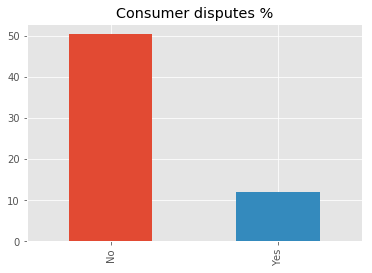

In [3]:
print(consumer_data.consumer_disputed.unique())
plt.title(r'Consumer disputes %')
(consumer_data['consumer_disputed'].value_counts()*100 / len(consumer_data)).plot.bar()

In [4]:
print('Percentage of NA information about if a dispute option is available',consumer_data.consumer_disputed.isna().sum()*100.0/len(consumer_data))

Percentage of NA information about if a dispute option is available 37.5230371383


From the 1230079 entries of data available, just 62% of the data has information about disputes.

## What happened with the other??

In the 38% of the cases the customer dont have chance to start a dispute?

In [5]:
nodispute=consumer_data[(consumer_data['consumer_disputed']!='Yes')&(consumer_data['consumer_disputed']!='No')]
series1=nodispute['product'].value_counts()*100 / len(consumer_data)
series2=consumer_data[consumer_data['consumer_disputed']=='No']['product'].value_counts()*100 / len(consumer_data)
series3=consumer_data[consumer_data['consumer_disputed']=='Yes']['product'].value_counts()*100 / len(consumer_data)


df = pd.DataFrame({'% NaN Dispute':series1.values,'Product':series1.index,})
df2= pd.DataFrame({'Product':series2.index, '% No Dispute':series2.values})
df3= pd.DataFrame({'Product':series3.index, '% Yes Dispute':series3.values})

df=pd.merge(df, pd.merge(df3, df2,on='Product',how='outer'),on='Product',how='outer')
df=df[['Product','% NaN Dispute','% No Dispute','% Yes Dispute']]
df

,Product,% NaN Dispute,% No Dispute,% Yes Dispute
0,"Credit reporting, credit repair services, or o...",16.347405,NaN,NaN
1,Debt collection,7.285792,9.772868,2.083931
2,Mortgage,3.792114,14.269978,4.176073
3,Credit card or prepaid card,3.473598,NaN,NaN
4,Checking or savings account,2.983711,0.000244,NaN
5,Student loan,1.414706,2.162544,0.482571
6,Vehicle loan or lease,0.834743,NaN,NaN
7,"Money transfer, virtual currency, or money ser...",0.752309,NaN,NaN
8,"Payday loan, title loan, or personal loan",0.638658,NaN,NaN
9,Credit reporting,NaN,9.618813,1.797689


C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:177: UserWarning: The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The left and right margins cannot be made large '


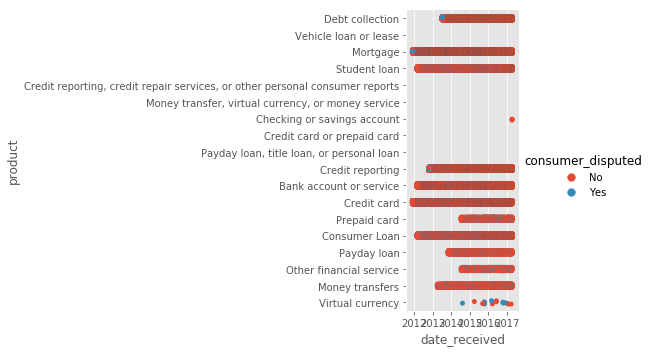

In [6]:
sns.catplot(x="date_received", y="product", hue="consumer_disputed",data=consumer_data)

Looks like for Products such:
'Credit card or prepaid card'
'Money transfer'
'Vehicle loan or lease'
'Money transfer, virtual currency, or money ser...'
'Payday loan, title loan, or personal loan'

there is not information about complains... 

I just want to check if it is due to some kind of company politics.

In [7]:
series4=nodispute['company'].value_counts()*100 / len(consumer_data)
series5=consumer_data[consumer_data['consumer_disputed']=='No']['company'].value_counts()*100 / len(consumer_data)
series6=consumer_data[consumer_data['consumer_disputed']=='Yes']['company'].value_counts()*100 / len(consumer_data)

df4 = pd.DataFrame({'% NaN Dispute':series4.values,'Company':series4.index,})
df5 = pd.DataFrame({'% No Dispute':series5.values,'Company':series5.index,})
df6 = pd.DataFrame({'% Yes Dispute':series6.values,'Company':series6.index,})

df4=pd.merge(df4, pd.merge(df6, df5,on='Company',how='outer'),on='Company',how='outer')
df4=df4[['Company','% NaN Dispute','% No Dispute','% Yes Dispute']]
df4

,Company,% NaN Dispute,% No Dispute,% Yes Dispute
0,"EQUIFAX, INC.",4.923098,3.114515,0.819378
1,Experian Information Solutions Inc.,4.188268,3.275562,0.433306
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",4.008767,2.793967,0.458345
3,JPMORGAN CHASE & CO.,1.292762,2.691453,0.774178
4,WELLS FARGO & COMPANY,1.270975,3.412464,0.952540
5,"BANK OF AMERICA, NATIONAL ASSOCIATION",1.207727,4.195259,1.169600
6,"CITIBANK, N.A.",1.050908,2.282049,0.544437
7,CAPITAL ONE FINANCIAL CORPORATION,1.045868,1.354303,0.297135
8,"Navient Solutions, LLC.",0.850758,1.212849,0.250634
9,SYNCHRONY FINANCIAL,0.644349,0.898723,0.159746


In [8]:
df4['new_column'] = np.where(df4['% No Dispute'].isnull() & df4['% Yes Dispute'].isnull(), 'nulls', 'disputes')
df4[df4['new_column']=='nulls']


,Company,% NaN Dispute,% No Dispute,% Yes Dispute,new_column
158,"The Outsource Group, Inc",0.019755,NaN,NaN,nulls
174,"Waypoint Resource Group, LLC",0.017235,NaN,NaN,nulls
218,Ameritech Financial,0.012926,NaN,NaN,nulls
298,"Sequium Asset Solutions, LLC",0.008211,NaN,NaN,nulls
303,Kashia Services,0.008048,NaN,NaN,nulls
403,STERLING BANCORP,0.005284,NaN,NaN,nulls
433,JPL Recovery Solutions,0.004878,NaN,NaN,nulls
490,FULTON FINANCIAL CORPORATION,0.004065,NaN,NaN,nulls
543,First Technology Federal Credit Union,0.003414,NaN,NaN,nulls
564,"LCO Financial Services, LLC",0.003252,NaN,NaN,nulls


In [9]:
df4[df4['new_column']=='nulls'].Company.unique()


array(['The Outsource Group, Inc', 'Waypoint Resource Group, LLC',
       'Ameritech Financial', 'Sequium Asset Solutions, LLC',
       'Kashia Services', 'STERLING BANCORP', 'JPL Recovery Solutions',
       'FULTON FINANCIAL CORPORATION',
       'First Technology Federal Credit Union',
       'LCO Financial Services, LLC', 'Activehours', 'BANK OZK',
       'Certegy Holdings, LLC', 'Upgrade, Inc.', 'SOUTH STATE BANK',
       'Payward Ventures Inc. dba Kraken', 'Premier Holdings',
       'Cordoza & Wexler Recovery Services', 'NPAS, Inc.',
       'Motolease, LLC', 'UNITED BANKSHARES, INC.',
       'Winklevoss Exchange LLC', 'RAS LaVrar, LLC',
       'HOME BANCSHARES, INC.', 'FIRST INTERSTATE BANCSYSTEM, INC.',
       'TOLEDO FINANCE CORPORATION', 'Debt Relief Center',
       'Ascendium Education Group',
       'National Default Servicing Corporation',
       'YAMAHA MOTOR FINANCE CORPORATION USA',
       'UNION BANKSHARES CORPORATION',
       'SIMMONS FIRST NATIONAL CORPORATION', 'Capita

In [10]:
len(df4[df4['new_column']=='nulls'].Company.unique())

921

## From the last table I can see that 921 companies have nulls values for costumer started a dispute.

This didnt clarify why there is lack of information if a dispute option was available for customers in some data.

In [11]:
series7=nodispute['company_response_to_consumer'].value_counts()*100 / len(consumer_data)
series8=consumer_data[consumer_data['consumer_disputed']=='No']['company_response_to_consumer'].value_counts()*100 / len(consumer_data)
series9=consumer_data[consumer_data['consumer_disputed']=='Yes']['company_response_to_consumer'].value_counts()*100 / len(consumer_data)

df7 = pd.DataFrame({'% NaN Dispute':series7.values,'Company_response':series7.index,})
df8 = pd.DataFrame({'% No Dispute':series8.values,'Company_response':series8.index,})
df9 = pd.DataFrame({'% Yes Dispute':series9.values,'Company_response':series9.index,})

df7=pd.merge(df7, pd.merge(df9, df8,on='Company_response',how='outer'),on='Company_response',how='outer')
df7=df7[['Company_response','% NaN Dispute','% No Dispute','% Yes Dispute']]
df7

,Company_response,% NaN Dispute,% No Dispute,% Yes Dispute
0,Closed with explanation,30.479994,37.003477,9.974563
1,Closed with non-monetary relief,4.552065,6.855332,0.902218
2,Closed with monetary relief,1.683063,3.734801,0.442167
3,In progress,0.567768,NaN,NaN
4,Untimely response,0.239741,0.248683,0.000163
5,Closed without relief,NaN,1.061477,0.391113
6,Closed,NaN,1.137000,0.294697
7,Closed with relief,NaN,0.373635,0.057557


<Figure size 432x288 with 0 Axes>

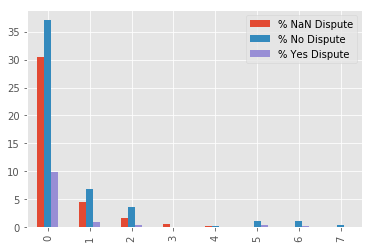

In [12]:
plt.figure();

df7.plot(kind='bar');

As I expected: there is not information about if a dispute option was available for the cases that are still 'in progress' .

But also there are a lot of closed cases without information about if a dispute was possible.

In this kernel I will predict first in which cases customers asked for a dispute, and later figure out in what situations dispute information is not available.

## Having the opportunity of submit a dispute... Will the customer submit one??

In [13]:
dispute_data=consumer_data[(consumer_data['consumer_disputed']=='Yes')|(consumer_data['consumer_disputed']=='No')]
dispute_data.describe()

#dispute_data.columns

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
count,768516,768516,533350,768516,313098,164083,195709,768516,762865,722002,107963,297926,768516,768516,768515,768516,768516,768516
unique,1970,13,50,99,61,160989,10,4293,62,18965,3,4,6,2049,7,2,2,768516
top,2017-01-19 00:00:00,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",Account status,I am filing this complaint because Experian ha...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,300XX,Older American,Consent provided,Web,2017-01-19 00:00:00,Closed with explanation,Yes,No,1358044
freq,2070,226901,86636,112311,37057,103,95588,65992,110645,2919,61898,164111,523110,1613,577867,746964,620138,1
first,2011-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01 00:00:00,NaN,NaN,NaN,NaN
last,2017-04-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17 00:00:00,NaN,NaN,NaN,NaN


Some of data seems not relevant like date_received and date_sent_to_company, since the same website claims to receive thousands every week. 

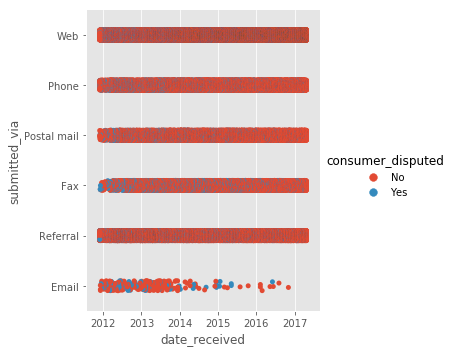

In [14]:
#print(type(dispute_data['date_received'].iloc[3]))
sns.catplot(x="date_received", y="submitted_via", hue="consumer_disputed",data=dispute_data)

The companies that have dispute data available:

In [15]:
print('rows without company name information',dispute_data.company.isna().sum())
print(dispute_data['company'].value_counts())

rows without company name information 0
BANK OF AMERICA, NATIONAL ASSOCIATION         65992
WELLS FARGO & COMPANY                         53693
EQUIFAX, INC.                                 48390
Experian Information Solutions Inc.           45622
JPMORGAN CHASE & CO.                          42630
TRANSUNION INTERMEDIATE HOLDINGS, INC.        40006
CITIBANK, N.A.                                34768
OCWEN LOAN SERVICING LLC                      24093
CAPITAL ONE FINANCIAL CORPORATION             20314
Navient Solutions, LLC.                       18002
NATIONSTAR MORTGAGE                           16222
SYNCHRONY FINANCIAL                           13020
U.S. BANCORP                                  12347
Ditech Financial LLC                          11476
PNC Bank N.A.                                  8666
AMERICAN EXPRESS COMPANY                       8298
ENCORE CAPITAL GROUP INC.                      7843
HSBC NORTH AMERICA HOLDINGS INC.               7209
DISCOVER BANK           

Since I have 4293 different companies I decided group the companies with less than 5000 disputes:
- Medium companies with 1000-5000 disputes
- Small companies with 100-1000 disputes
- Petite companies 2-100 disputes
- Unique cases, companies with one dispute.

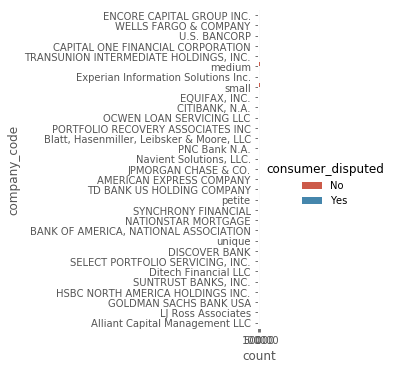

In [16]:
####count companies disputes and create dictionary
company_counts=dispute_data['company'].value_counts()
dfcompany_counts = pd.DataFrame({'counts':company_counts.values,'dic_company':company_counts.index,'companies':company_counts.index,})

dfcompany_counts['dic_company'] =["unique" if x==1 else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]
dfcompany_counts['dic_company'] =["petite" if (x>1 and x<100) else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]
dfcompany_counts['dic_company'] =['small' if (x>100 and x<1000)  else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]
dfcompany_counts['dic_company'] =['medium' if (x>=1000 and x<5000) else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]

company_dict = dict(zip(dfcompany_counts.companies, dfcompany_counts.dic_company))
 
dispute_data['company_code']=dispute_data['company'].map(company_dict)

sns.catplot(y="company_code", hue="consumer_disputed", kind="count",data=dispute_data)


In [17]:
codeno=dispute_data[dispute_data['consumer_disputed']=='No']['company_code'].value_counts()/len(dispute_data)
codeyes=dispute_data[dispute_data['consumer_disputed']=='Yes']['company_code'].value_counts()/len(dispute_data)

dfcodeno = pd.DataFrame({' % No Dispute':codeno.values,'company_code':codeno.index,})
dfcodeyes = pd.DataFrame({' % Yes Dispute':codeyes.values,'company_code':codeyes.index,})

dfcodeno=pd.merge(dfcodeno,dfcodeyes,on='company_code',how='outer')
dfcodeno['ratio: dispute/nodispute']=[ x/dfcodeno[' % Yes Dispute'].iloc[i] for i,x in enumerate(dfcodeno[' % No Dispute'])]

dfcodeno=dfcodeno[['company_code',' % No Dispute',' % Yes Dispute','ratio: dispute/nodispute']]

dfcodeno

,company_code,% No Dispute,% Yes Dispute,ratio: dispute/nodispute
0,medium,0.118302,0.026804,4.413661
1,small,0.103998,0.024165,4.303699
2,"BANK OF AMERICA, NATIONAL ASSOCIATION",0.067149,0.018720,3.586919
3,WELLS FARGO & COMPANY,0.054620,0.015246,3.582487
4,Experian Information Solutions Inc.,0.052428,0.006935,7.559475
5,petite,0.051918,0.011831,4.388473
6,"EQUIFAX, INC.",0.049851,0.013115,3.801072
7,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",0.044720,0.007336,6.095779
8,JPMORGAN CHASE & CO.,0.043079,0.012391,3.476531
9,"CITIBANK, N.A.",0.036526,0.008714,4.191578


TRANSUNION INTERMEDIATE HOLDINGS, INC and Experian Information Solutions Inc are the companies with higher rato of disputes.

Also looks like in the case of unique complains most of the customers started a dispute.

In [18]:
dfcodeno.describe()

,% No Dispute,% Yes Dispute,ratio: dispute/nodispute
count,31.000000,31.000000,31.000000
mean,0.026030,0.006228,4.119987
std,0.030032,0.007088,1.119824
min,0.000098,0.000027,2.683089
25%,0.006264,0.001690,3.496724
50%,0.012615,0.003205,3.761905
75%,0.043900,0.008078,4.447222
max,0.118302,0.026804,7.559475


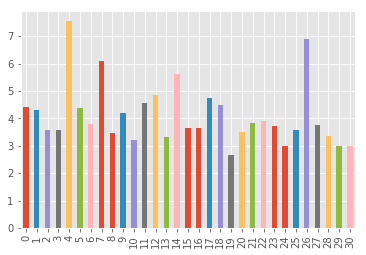

In [19]:
fig, ax = subplots()
#plt.figure();
dfcodeno['ratio: dispute/nodispute'].plot(kind='bar')

In [20]:
len(dispute_data.issue.unique())

99

There are 99 different isssues for the complains, I will group them similar to the companies values.

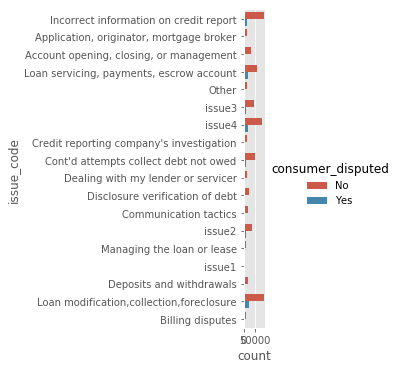

In [21]:
issue_counts=dispute_data['issue'].value_counts()
dfissue_counts = pd.DataFrame({'counts':issue_counts.values,'dic_issue':issue_counts.index,'issue':issue_counts.index,})

dfissue_counts['dic_issue'] =['issue1' if (x<500) else dfissue_counts['dic_issue'].iloc[i] for i,x in enumerate(dfissue_counts['counts'])]
dfissue_counts['dic_issue'] =['issue2' if (x>=500 and x<3000) else dfissue_counts['dic_issue'].iloc[i] for i,x in enumerate(dfissue_counts['counts'])]
dfissue_counts['dic_issue'] =['issue3' if (x>=3000 and x<7000) else dfissue_counts['dic_issue'].iloc[i] for i,x in enumerate(dfissue_counts['counts'])]
dfissue_counts['dic_issue'] =['issue4' if (x>=7000 and x<14000) else dfissue_counts['dic_issue'].iloc[i] for i,x in enumerate(dfissue_counts['counts'])]
#dfissue_counts
issue_dict = dict(zip(dfissue_counts.issue, dfissue_counts.dic_issue))
 
dispute_data['issue_code']=dispute_data['issue'].map(issue_dict)

sns.catplot(y="issue_code", hue="consumer_disputed", kind="count",data=dispute_data)


In [22]:
issueno=dispute_data[dispute_data['consumer_disputed']=='No']['issue_code'].value_counts()/len(dispute_data)
issueyes=dispute_data[dispute_data['consumer_disputed']=='Yes']['issue_code'].value_counts()/len(dispute_data)

dfissueno = pd.DataFrame({' % No Dispute':issueno.values,'issue_code':issueno.index,})
dfissueyes = pd.DataFrame({' % Yes Dispute':issueyes.values,'issue_code':issueyes.index,})

dfissueno=pd.merge(dfissueno,dfissueyes,on='issue_code',how='outer')
dfissueno['ratio: dispute/nodispute']=[ x/dfissueno[' % Yes Dispute'].iloc[i] for i,x in enumerate(dfissueno[' % No Dispute'])]

dfissueno=dfissueno[['issue_code',' % No Dispute',' % Yes Dispute','ratio: dispute/nodispute']]

dfissueno

,issue_code,% No Dispute,% Yes Dispute,ratio: dispute/nodispute
0,Incorrect information on credit report,0.114755,0.018861,6.084236
1,"Loan modification,collection,foreclosure",0.113851,0.032290,3.525932
2,issue4,0.102004,0.023111,4.413715
3,"Loan servicing, payments, escrow account",0.077482,0.023145,3.347726
4,Cont'd attempts collect debt not owed,0.065433,0.013543,4.831476
5,issue3,0.060630,0.015254,3.974665
6,issue2,0.044583,0.010445,4.268469
7,"Account opening, closing, or management",0.039699,0.009697,4.094069
8,Disclosure verification of debt,0.031838,0.008241,3.863572
9,Communication tactics,0.027003,0.004019,6.718032


In [23]:
dfissueno.describe()

,% No Dispute,% Yes Dispute,ratio: dispute/nodispute
count,18.000000,18.000000,18.000000
mean,0.044829,0.010726,4.216853
std,0.035887,0.008615,0.962089
min,0.006609,0.001636,2.871040
25%,0.016631,0.004308,3.648514
50%,0.029420,0.007016,4.067321
75%,0.064232,0.014826,4.453489
max,0.114755,0.032290,6.718032


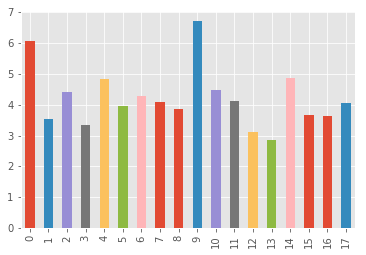

In [24]:
fig, ax = subplots()
#plt.figure();
dfissueno['ratio: dispute/nodispute'].plot(kind='bar')

C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:177: UserWarning: The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The left and right margins cannot be made large '


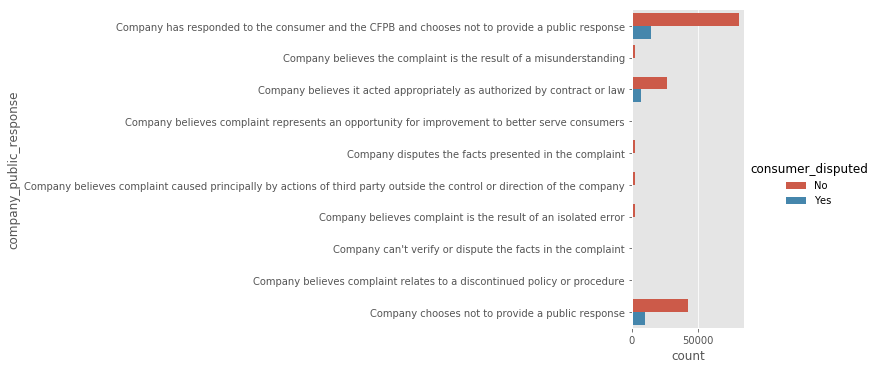

In [25]:
sns.catplot(y="company_public_response", hue="consumer_disputed", kind="count",data=dispute_data)


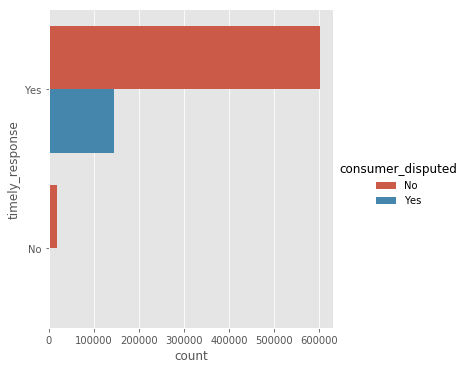

In [26]:
sns.catplot(y="timely_response", hue="consumer_disputed", kind="count",data=dispute_data);

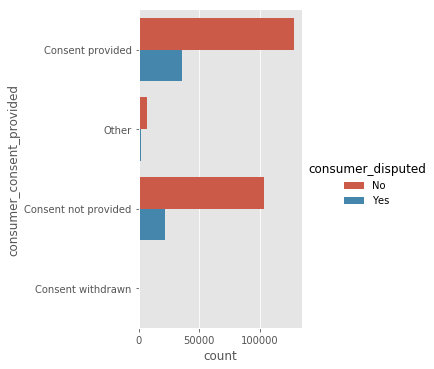

In [27]:
sns.catplot(y="consumer_consent_provided", hue="consumer_disputed", kind="count",data=dispute_data);

[nan 'Older American' 'Servicemember' 'Older American, Servicemember']


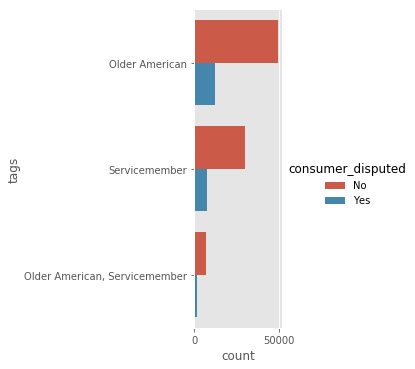

In [28]:
print(dispute_data.tags.unique())
sns.catplot(y="tags", hue="consumer_disputed", kind="count",data=dispute_data);

In [29]:
tagsno=dispute_data[dispute_data['consumer_disputed']=='No']['tags'].value_counts()/len(dispute_data)
tagsyes=dispute_data[dispute_data['consumer_disputed']=='Yes']['tags'].value_counts()/len(dispute_data)

dftagsno = pd.DataFrame({' % No Dispute':tagsno.values,'tags':tagsno.index,})
dftagsyes = pd.DataFrame({' % Yes Dispute':tagsyes.values,'tags':tagsyes.index,})

dftagsno=pd.merge(dftagsno,dftagsyes,on='tags',how='outer')
dftagsno=dftagsno[['tags',' % No Dispute',' % Yes Dispute']]
dftagsno

,tags,% No Dispute,% Yes Dispute
0,Older American,0.064248,0.016294
1,Servicemember,0.038996,0.009730
2,"Older American, Servicemember",0.009045,0.002169


In [30]:
stateno=dispute_data[dispute_data['consumer_disputed']=='No']['state'].value_counts()/len(dispute_data)
stateyes=dispute_data[dispute_data['consumer_disputed']=='Yes']['state'].value_counts()/len(dispute_data)
#print(len(dispute_data.state.unique()),dispute_data.state.unique())
dfstateno = pd.DataFrame({' % No Dispute':stateno.values,'State':stateno.index,})
dfstateyes = pd.DataFrame({' % Yes Dispute':stateyes.values,'State':stateyes.index,})

dfstateno=pd.merge(dfstateno,dfstateyes,on='State',how='outer')

dfstateno['ratio: dispute/nodispute']=[ x/dfstateno[' % Yes Dispute'].iloc[i] for i,x in enumerate(dfstateno[' % No Dispute'])]


dfstateno=dfstateno[['State',' % No Dispute',' % Yes Dispute','ratio: dispute/nodispute']]
dfstateno

,State,% No Dispute,% Yes Dispute,ratio: dispute/nodispute
0,CA,0.114583,0.029389,3.898831
1,FL,0.077676,0.018092,4.293369
2,TX,0.063411,0.013898,4.562494
3,NY,0.055558,0.012805,4.338685
4,GA,0.038405,0.008770,4.379080
5,NJ,0.032124,0.007587,4.233922
6,IL,0.029445,0.007232,4.071429
7,PA,0.029198,0.006624,4.407582
8,VA,0.025266,0.006636,3.807255
9,OH,0.024940,0.005841,4.269771


In [31]:
dfstateno.describe()

,% No Dispute,% Yes Dispute,ratio: dispute/nodispute
count,62.000000,62.000000,62.000000
mean,0.012917,0.003094,4.206406
std,0.020361,0.004958,0.569722
min,0.000012,0.000004,2.250000
25%,0.001535,0.000339,3.862758
50%,0.004563,0.001082,4.301416
75%,0.015067,0.003756,4.499127
max,0.114583,0.029389,5.476027


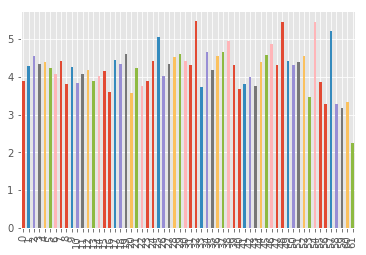

In [32]:
plt.figure();

dfstateno['ratio: dispute/nodispute'].plot(kind='bar');

# Creating the machine learning models

The features that I will explore are:
'product' (13), 'issue_code'(18), 'company_public_response'(10), 'company_code'(31), 'consumer_consent_provided'(4), 'submitted_via'(6), 'company_response_to_consumer'(7), 'timely_response'(2), 'consumer_disputed'(2) .

First I will create dummy variables:

In [33]:
dispute_data=pd.get_dummies(data=dispute_data, columns=['product'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['issue_code'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['company_public_response'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['company_code'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['consumer_consent_provided'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['submitted_via'])

dispute_data=pd.get_dummies(data=dispute_data, columns=['company_response_to_consumer'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['timely_response'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['consumer_disputed'])
              

In [34]:
#dispute_data.columns.tolist()
features=[ 'product_Bank account or service','product_Checking or savings account', 'product_Consumer Loan', 'product_Credit card',  'product_Credit reporting', 'product_Debt collection', 'product_Money transfers', 'product_Mortgage', 'product_Other financial service', 'product_Payday loan', 'product_Prepaid card', 'product_Student loan', 'product_Virtual currency', 'issue_code_Account opening, closing, or management', 'issue_code_Application, originator, mortgage broker', 'issue_code_Billing disputes', 'issue_code_Communication tactics', "issue_code_Cont'd attempts collect debt not owed", "issue_code_Credit reporting company's investigation", 'issue_code_Dealing with my lender or servicer', 'issue_code_Deposits and withdrawals', 'issue_code_Disclosure verification of debt', 'issue_code_Incorrect information on credit report', 'issue_code_Loan modification,collection,foreclosure', 'issue_code_Loan servicing, payments, escrow account', 'issue_code_Managing the loan or lease', 'issue_code_Other', 'issue_code_issue1', 'issue_code_issue2', 'issue_code_issue3', 'issue_code_issue4', 'company_public_response_Company believes complaint caused principally by actions of third party outside the control or direction of the company', 'company_public_response_Company believes complaint is the result of an isolated error', 'company_public_response_Company believes complaint relates to a discontinued policy or procedure', 'company_public_response_Company believes complaint represents an opportunity for improvement to better serve consumers', 'company_public_response_Company believes it acted appropriately as authorized by contract or law', 'company_public_response_Company believes the complaint is the result of a misunderstanding', "company_public_response_Company can't verify or dispute the facts in the complaint", 'company_public_response_Company chooses not to provide a public response', 'company_public_response_Company disputes the facts presented in the complaint', 'company_public_response_Company has responded to the consumer and the CFPB and chooses not to provide a public response', 'company_code_AMERICAN EXPRESS COMPANY', 'company_code_Alliant Capital Management LLC', 'company_code_BANK OF AMERICA, NATIONAL ASSOCIATION', 'company_code_Blatt, Hasenmiller, Leibsker & Moore, LLC', 'company_code_CAPITAL ONE FINANCIAL CORPORATION', 'company_code_CITIBANK, N.A.', 'company_code_DISCOVER BANK', 'company_code_Ditech Financial LLC', 'company_code_ENCORE CAPITAL GROUP INC.', 'company_code_EQUIFAX, INC.', 'company_code_Experian Information Solutions Inc.', 'company_code_GOLDMAN SACHS BANK USA', 'company_code_HSBC NORTH AMERICA HOLDINGS INC.', 'company_code_JPMORGAN CHASE & CO.', 'company_code_LJ Ross Associates', 'company_code_NATIONSTAR MORTGAGE', 'company_code_Navient Solutions, LLC.', 'company_code_OCWEN LOAN SERVICING LLC', 'company_code_PNC Bank N.A.', 'company_code_PORTFOLIO RECOVERY ASSOCIATES INC', 'company_code_SELECT PORTFOLIO SERVICING, INC.', 'company_code_SUNTRUST BANKS, INC.', 'company_code_SYNCHRONY FINANCIAL', 'company_code_TD BANK US HOLDING COMPANY', 'company_code_TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'company_code_U.S. BANCORP', 'company_code_WELLS FARGO & COMPANY', 'company_code_medium', 'company_code_petite', 'company_code_small', 'company_code_unique', 'consumer_consent_provided_Consent not provided', 'consumer_consent_provided_Consent provided', 'consumer_consent_provided_Consent withdrawn', 'consumer_consent_provided_Other', 'submitted_via_Email', 'submitted_via_Fax', 'submitted_via_Phone', 'submitted_via_Postal mail',  'submitted_via_Referral', 'submitted_via_Web', 'company_response_to_consumer_Closed', 'company_response_to_consumer_Closed with explanation', 'company_response_to_consumer_Closed with monetary relief', 'company_response_to_consumer_Closed with non-monetary relief', 'company_response_to_consumer_Closed with relief', 'company_response_to_consumer_Closed without relief', 'company_response_to_consumer_Untimely response', 'timely_response_Yes', 'consumer_disputed_Yes']
X=dispute_data[features]
corr = X.corr()
corr['consumer_disputed_Yes'].sort_values(ascending=False)

consumer_disputed_Yes                                                                                                                              1.000000
company_response_to_consumer_Closed with explanation                                                                                               0.084922
submitted_via_Web                                                                                                                                  0.064727
product_Mortgage                                                                                                                                   0.054644
consumer_consent_provided_Consent provided                                                                                                         0.033191
timely_response_Yes                                                                                                                                0.031770
issue_code_Loan servicing, payments, escrow account             

In [35]:
y = dispute_data['consumer_disputed_Yes']
features=[ 'product_Bank account or service','product_Checking or savings account', 'product_Consumer Loan', 'product_Credit card',  'product_Credit reporting', 'product_Debt collection', 'product_Money transfers', 'product_Mortgage', 'product_Other financial service', 'product_Payday loan', 'product_Prepaid card', 'product_Student loan', 'product_Virtual currency', 'issue_code_Account opening, closing, or management', 'issue_code_Application, originator, mortgage broker', 'issue_code_Billing disputes', 'issue_code_Communication tactics', "issue_code_Cont'd attempts collect debt not owed", "issue_code_Credit reporting company's investigation", 'issue_code_Dealing with my lender or servicer', 'issue_code_Deposits and withdrawals', 'issue_code_Disclosure verification of debt', 'issue_code_Incorrect information on credit report', 'issue_code_Loan modification,collection,foreclosure', 'issue_code_Loan servicing, payments, escrow account', 'issue_code_Managing the loan or lease', 'issue_code_Other', 'issue_code_issue1', 'issue_code_issue2', 'issue_code_issue3', 'issue_code_issue4', 'company_public_response_Company believes complaint caused principally by actions of third party outside the control or direction of the company', 'company_public_response_Company believes complaint is the result of an isolated error', 'company_public_response_Company believes complaint relates to a discontinued policy or procedure', 'company_public_response_Company believes complaint represents an opportunity for improvement to better serve consumers', 'company_public_response_Company believes it acted appropriately as authorized by contract or law', 'company_public_response_Company believes the complaint is the result of a misunderstanding', "company_public_response_Company can't verify or dispute the facts in the complaint", 'company_public_response_Company chooses not to provide a public response', 'company_public_response_Company disputes the facts presented in the complaint', 'company_public_response_Company has responded to the consumer and the CFPB and chooses not to provide a public response', 'company_code_AMERICAN EXPRESS COMPANY', 'company_code_Alliant Capital Management LLC', 'company_code_BANK OF AMERICA, NATIONAL ASSOCIATION', 'company_code_Blatt, Hasenmiller, Leibsker & Moore, LLC', 'company_code_CAPITAL ONE FINANCIAL CORPORATION', 'company_code_CITIBANK, N.A.', 'company_code_DISCOVER BANK', 'company_code_Ditech Financial LLC', 'company_code_ENCORE CAPITAL GROUP INC.', 'company_code_EQUIFAX, INC.', 'company_code_Experian Information Solutions Inc.', 'company_code_GOLDMAN SACHS BANK USA', 'company_code_HSBC NORTH AMERICA HOLDINGS INC.', 'company_code_JPMORGAN CHASE & CO.', 'company_code_LJ Ross Associates', 'company_code_NATIONSTAR MORTGAGE', 'company_code_Navient Solutions, LLC.', 'company_code_OCWEN LOAN SERVICING LLC', 'company_code_PNC Bank N.A.', 'company_code_PORTFOLIO RECOVERY ASSOCIATES INC', 'company_code_SELECT PORTFOLIO SERVICING, INC.', 'company_code_SUNTRUST BANKS, INC.', 'company_code_SYNCHRONY FINANCIAL', 'company_code_TD BANK US HOLDING COMPANY', 'company_code_TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'company_code_U.S. BANCORP', 'company_code_WELLS FARGO & COMPANY', 'company_code_medium', 'company_code_petite', 'company_code_small', 'company_code_unique', 'consumer_consent_provided_Consent not provided', 'consumer_consent_provided_Consent provided', 'consumer_consent_provided_Consent withdrawn', 'consumer_consent_provided_Other', 'submitted_via_Email', 'submitted_via_Fax', 'submitted_via_Phone', 'submitted_via_Postal mail',  'submitted_via_Referral', 'submitted_via_Web', 'company_response_to_consumer_Closed', 'company_response_to_consumer_Closed with explanation', 'company_response_to_consumer_Closed with monetary relief', 'company_response_to_consumer_Closed with non-monetary relief', 'company_response_to_consumer_Closed with relief', 'company_response_to_consumer_Closed without relief', 'company_response_to_consumer_Untimely response', 'timely_response_Yes']
X = dispute_data[features]
print(len(features))
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.4, random_state = 0)


90


# Machine learning models.

For the decision tree, first I will explore what is the optimum depth to obtain the best accuracy.

In [36]:
#accuracy=[]
#for i in range(1,90):
 #   decision_tree = DecisionTreeClassifier(max_depth = i)
 #   decision_tree.fit(train_X, train_y)
 #   accuracy.append(decision_tree.score(val_X, val_y))
 #   print(i,"Accuracy:", decision_tree.score(val_X, val_y))
    
#print(max(accuracy),accuracy.index(max(accuracy)))

In [37]:
decision_tree = DecisionTreeClassifier(max_depth = 34)
decision_tree.fit(train_X, train_y)
y_pred_tree = decision_tree .predict(val_X)

DecisionTree=[decision_tree.score(val_X, val_y),precision_score(val_y, y_pred_tree),recall_score(val_y, y_pred_tree),f1_score(val_y, y_pred_tree)]
results=pd.DataFrame(DecisionTree,columns=['DecisionTree'],index=['Accuracy:', 'Precision:', 'Recall:','F1:'])

forest = RandomForestClassifier(random_state=1)
forest.fit(train_X, train_y)
y_pred_for = forest.predict(val_X)

RandomForest=[forest.score(val_X, val_y),precision_score(val_y, y_pred_for),recall_score(val_y, y_pred_for),f1_score(val_y,y_pred_for)]

results['RandomForest']=RandomForest

logreg = LogisticRegression(solver='liblinear')
logreg.fit(train_X, train_y)
y_pred_log =logreg.predict(val_X)

LogisticRegression=[logreg.score(val_X, val_y),precision_score(val_y, y_pred_log),recall_score(val_y, y_pred_log),f1_score(val_y,y_pred_log)]

results['LogisticRegression']=LogisticRegression

C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


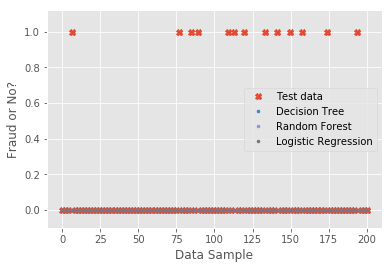

In [38]:
preds=pd.DataFrame()
preds['validation']=val_y
preds['tree']=y_pred_tree
#preds['neighbors']=y_pred_nei
preds['forest']=y_pred_for
preds['logistic']=y_pred_log

preds.describe()
pr=preds.sample(n=100)
ind = np.linspace(0,200,100)# len(val_y),len(val_y))
plt.xlabel('Data Sample')
plt.ylabel('Fraud or No?') 

plt.plot(ind, pr['validation'],'X', markersize=6,label='Test data' )
plt.plot(ind,pr['tree'], '.', markersize=5,label='Decision Tree')
#plt.plot(ind,pr['neighbors'], '.', markersize=5,label='K Neighbors')
plt.plot(ind,pr['forest'], '.', markersize=5,label='Random Forest')
plt.plot(ind,pr['logistic'], '.', markersize=5,label='Logistic Regression')
plt.legend(loc='right')
plt.ylim(-.1,1.12)
plt.show()

The machine learning models performed poorly (acceptable accuracy 80% but with a 2% F1). 

In the next notebook, I will try a different approach by analyzing the costumer narrative too.

In [39]:
results

,DecisionTree,RandomForest,LogisticRegression
Accuracy:,0.803014,0.802207,0.80654
Precision:,0.273601,0.284605,0.00000
Recall:,0.011014,0.014797,0.00000
F1:,0.021175,0.028132,0.00000
